In [99]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# making folder names as class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# how much batches we have
len(dataset)

68

In [6]:
# printing the shape of the first patch
# 32 is the size of the batch 
# 256 is the hight and width of the imges in the batch
# 3 is rgb channels
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


In [7]:
# printing the first img in the first batch

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[112. 100. 110.]
  [108.  96. 106.]
  [104.  92. 102.]
  ...
  [100.  88.  92.]
  [ 97.  85.  89.]
  [ 93.  81.  85.]]

 [[102.  90. 100.]
  [102.  90. 100.]
  [104.  92. 102.]
  ...
  [ 92.  80.  84.]
  [ 89.  77.  81.]
  [ 87.  75.  79.]]

 [[101.  89.  99.]
  [104.  92. 102.]
  [108.  96. 106.]
  ...
  [ 89.  77.  81.]
  [ 90.  78.  82.]
  [ 92.  80.  84.]]

 ...

 [[156. 150. 162.]
  [158. 152. 164.]
  [159. 153. 165.]
  ...
  [152. 145. 152.]
  [151. 144. 151.]
  [150. 143. 150.]]

 [[154. 148. 160.]
  [156. 150. 162.]
  [156. 150. 162.]
  ...
  [149. 142. 149.]
  [149. 142. 149.]
  [149. 142. 149.]]

 [[152. 146. 158.]
  [153. 147. 159.]
  [151. 145. 157.]
  ...
  [146. 139. 146.]
  [146. 139. 146.]
  [147. 140. 147.]]]


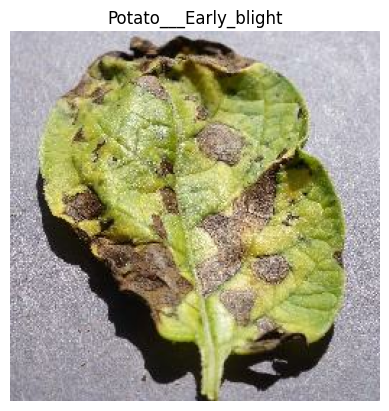

In [8]:
# visualising the first img using matplolib

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

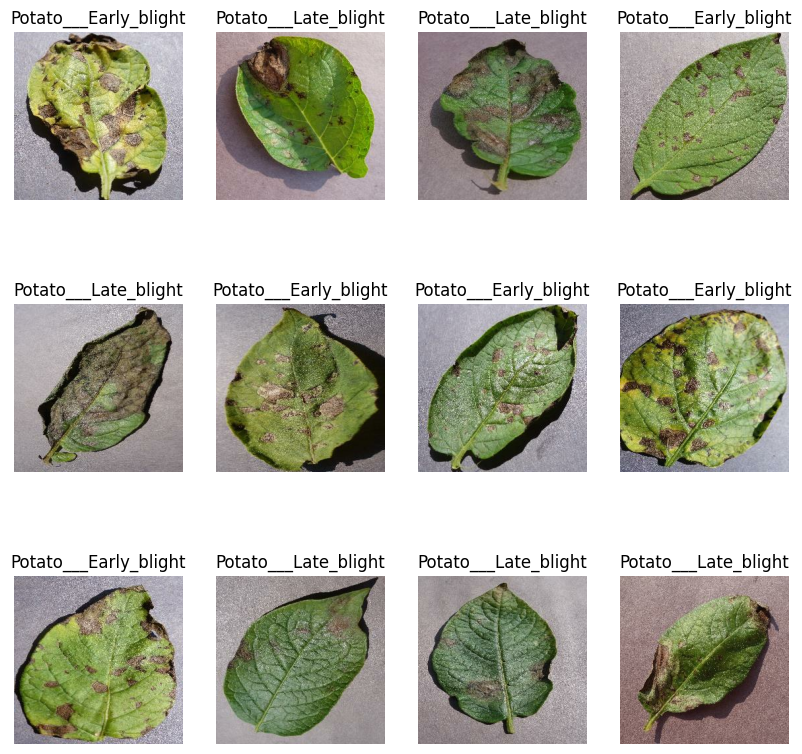

In [9]:
# visualising the first img using matplolib
plt.figure(figsize=(10,10))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [10]:
# 80% ==> training
# after each epoch do alidition from the 10 percent of images
# 20% ==> 10% validation, 10% test

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
# if we have an img that is not 255 by 255 we resize it
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
# data augmantatin to make our model robust we make adustmint to the imges to make them little difrent, creating 4 new samples to train our model on them and make our model diffrend
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax') #three nurons and activion is softmax
])

model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
# conv2d parameters
#1- num if filters
#2- size of the filter
# what is filter: you make filter for nose / filter for ear / filter for mouse  to
# than you can tell if its a cat head
#the same thing for body parts than you can say its a cats body
# activation layer relu becouse its fast to compute 
#----------------------------------------------
#we are using max pooling

In [28]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 47s 840ms/step - loss: 0.9251 - accuracy: 0.4797 - val_loss: 0.8770 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - 46s 843ms/step - loss: 0.8018 - accuracy: 0.6117 - val_loss: 0.7528 - val_accuracy: 0.6250
Epoch 3/50
54/54 [==============================] - 45s 832ms/step - loss: 0.5559 - accuracy: 0.7569 - val_loss: 0.4330 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 43s 804ms/step - loss: 0.4307 - accuracy: 0.8258 - val_loss: 0.3323 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 43s 803ms/step - loss: 0.3389 - accuracy: 0.8611 - val_loss: 0.2892 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 44s 820ms/step - loss: 0.2971 - accuracy: 0.8814 - val_loss: 0.3248 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 43s 801ms/step - loss: 0.2815 - accuracy: 0.8918 - val_loss: 0.3102 - val_accuracy: 0.8698

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 173ms/step - loss: 0.0445 - accuracy: 0.9883


In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.47974535822868347,
 0.6116898059844971,
 0.7569444179534912,
 0.8258101940155029,
 0.8611111044883728,
 0.8813657164573669,
 0.8917824029922485,
 0.8993055820465088,
 0.9212962985038757,
 0.9160879850387573,
 0.9270833134651184,
 0.9357638955116272,
 0.9293981194496155,
 0.9571759104728699,
 0.9456018805503845,
 0.9670138955116272,
 0.9375,
 0.9484953880310059,
 0.9681712985038757,
 0.9780092835426331,
 0.9710648059844971,
 0.9803240895271301,
 0.9820601940155029,
 0.96875,
 0.9809027910232544,
 0.9756944179534912,
 0.9785879850387573,
 0.9641203880310059,
 0.9756944179534912,
 0.9855324029922485,
 0.9884259104728699,
 0.9837962985038757,
 0.9739583134651184,
 0.9907407164573669,
 0.9890046119689941,
 0.9907407164573669,
 0.9872685074806213,
 0.9780092835426331,
 0.9861111044883728,
 0.9826388955116272,
 0.9924768805503845,
 0.9930555820465088,
 0.9866898059844971,
 0.9890046119689941,
 0.9907407164573669,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184,
 0.99189811944

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

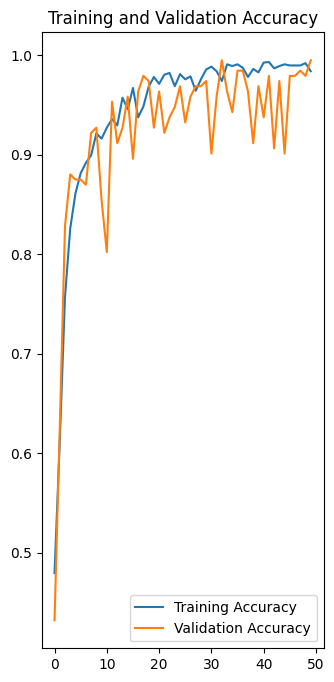

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

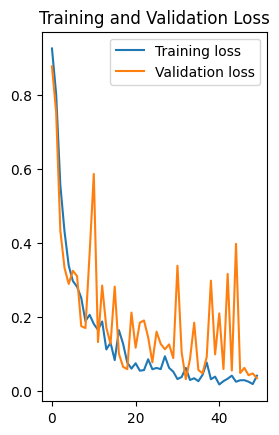

In [43]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training loss')
plt.plot(range(EPOCHS),val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 0s 165ms/step
predicted label: Potato___Late_blight


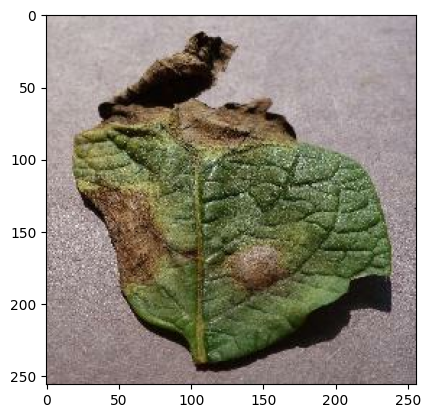

In [81]:
# making prediction
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_pridiction = model.predict(image_batch)
#     print(batch_pridiction[0])
    print("predicted label:",class_names[np.argmax(batch_pridiction[0])])


In [93]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
# 100% of confidance means acuracy of 100%

1/1 [==============================] - 0s 22ms/step


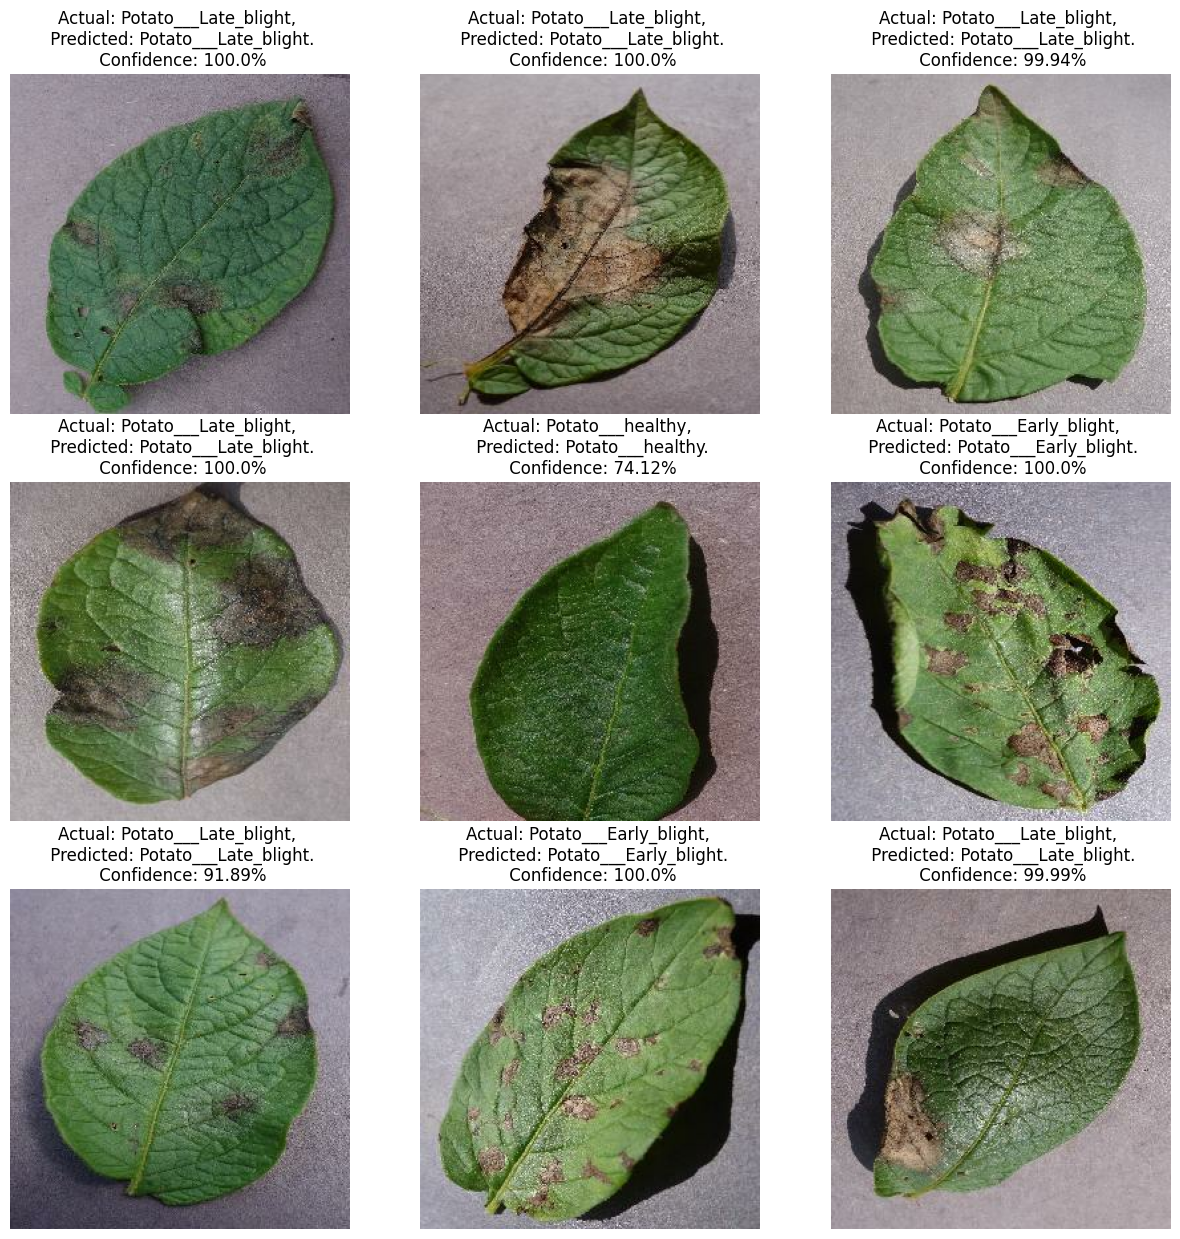

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [101]:
model_version=max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
